In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import warnings
warnings.filterwarnings("ignore")


In [225]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [226]:
df1 = df["tweets"]
df2 = df["label"]

In [227]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [228]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
0,3
1,1
2,1
3,1
4,0
...,...
996,3
997,3
998,3
999,4


In [229]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [230]:
y.shape

(1001, 5)

In [231]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [232]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2268 unique tokens.


In [233]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(tweets)

In [234]:
# pad documents to a max length of 14 words
maxlen = 14
X = pad_sequences(sequences, maxlen=maxlen)

In [235]:
X.shape

(1001, 14)

In [236]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [237]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 14), (301, 14), (700, 5), (301, 5))

In [238]:
# SimpleRNN
vocab_size = 2269
output_dim = 32
maxlen = 14
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [239]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 14, 32)            72608     
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 14, 32)            2080      
                                                                 
 dropout_22 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 14, 32)            2080      
                                                                 
 dropout_23 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 5)               

In [240]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
16/16 [==============================] - 8s 76ms/step - loss: 1.5321 - accuracy: 0.3783 - val_loss: 1.3860 - val_accuracy: 0.4502
Epoch 2/10
16/16 [==============================] - 0s 22ms/step - loss: 1.2522 - accuracy: 0.5378 - val_loss: 1.4118 - val_accuracy: 0.4313
Epoch 3/10
16/16 [==============================] - 0s 23ms/step - loss: 1.0661 - accuracy: 0.6217 - val_loss: 1.4011 - val_accuracy: 0.4265
Epoch 4/10
16/16 [==============================] - 0s 22ms/step - loss: 0.8365 - accuracy: 0.7607 - val_loss: 1.4629 - val_accuracy: 0.4265
Epoch 5/10
16/16 [==============================] - 0s 23ms/step - loss: 0.6381 - accuracy: 0.8384 - val_loss: 1.5420 - val_accuracy: 0.4076
Epoch 6/10
16/16 [==============================] - 0s 26ms/step - loss: 0.4478 - accuracy: 0.8998 - val_loss: 1.5888 - val_accuracy: 0.4313
Epoch 7/10
16/16 [==============================] - 0s 26ms/step - loss: 0.3279 - accuracy: 0.9325 - val_loss: 1.6660 - val_accuracy: 0.4313
Epoch 8/10
16

In [242]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [243]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 14, 32)            72608     
                                                                 
 lstm (LSTM)                 (None, 14, 32)            8320      
                                                                 
 dropout_24 (Dropout)        (None, 14, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_25 (Dropout)        (None, 14, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_12 (Dense)            (None, 5)               

In [244]:
start = time.time()
# Fit the model to the training set
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
16/16 [==============================] - 18s 223ms/step - loss: 1.5709 - accuracy: 0.3558 - val_loss: 1.4905 - val_accuracy: 0.3697
Epoch 2/10
16/16 [==============================] - 1s 40ms/step - loss: 1.4261 - accuracy: 0.3783 - val_loss: 1.3841 - val_accuracy: 0.4692
Epoch 3/10
16/16 [==============================] - 1s 56ms/step - loss: 1.3452 - accuracy: 0.4888 - val_loss: 1.3259 - val_accuracy: 0.4929
Epoch 4/10
16/16 [==============================] - 1s 40ms/step - loss: 1.2904 - accuracy: 0.5010 - val_loss: 1.3252 - val_accuracy: 0.5024
Epoch 5/10
16/16 [==============================] - 1s 53ms/step - loss: 1.2280 - accuracy: 0.5256 - val_loss: 1.2890 - val_accuracy: 0.5071
Epoch 6/10
16/16 [==============================] - 1s 56ms/step - loss: 1.1075 - accuracy: 0.5562 - val_loss: 1.2358 - val_accuracy: 0.5071
Epoch 7/10
16/16 [==============================] - 1s 40ms/step - loss: 0.9706 - accuracy: 0.5930 - val_loss: 1.3864 - val_accuracy: 0.5166
Epoch 8/10


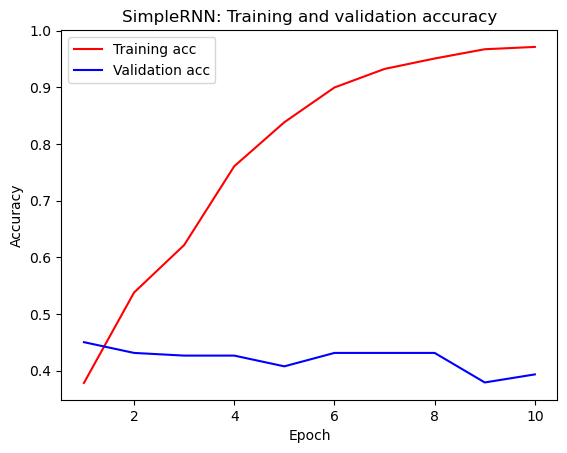

In [249]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

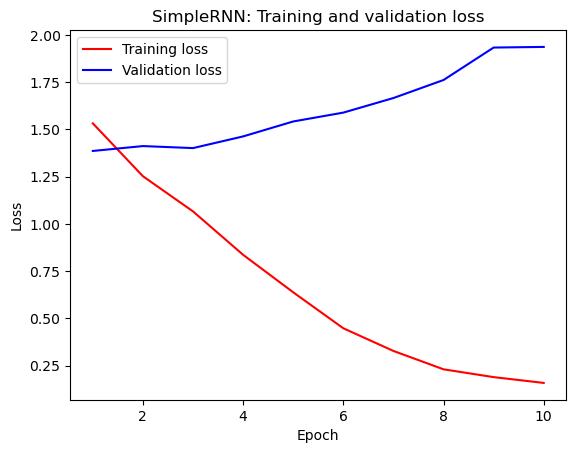

In [253]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

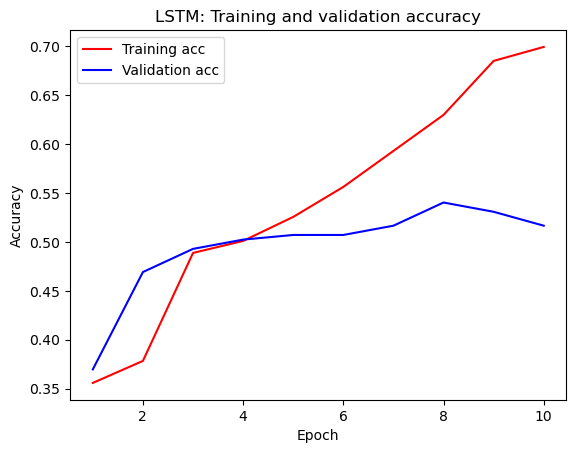

In [254]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

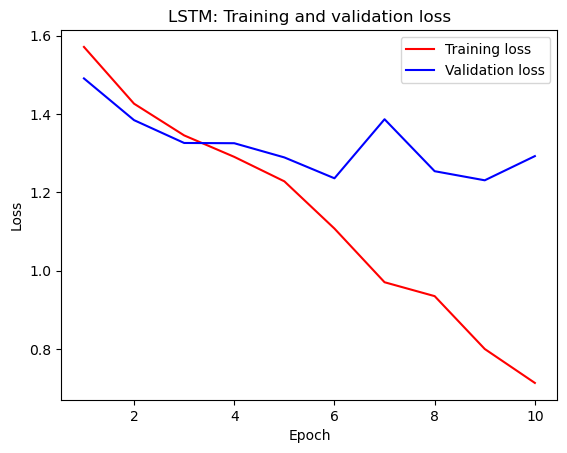

In [255]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()